# Plot yoda files

In [1]:
import yoda
import os
import numpy as np
import matplotlib.pyplot as plt

Welcome to JupyROOT 6.30/02


In [2]:
hist_name='d01-x01-y01'
data_hist_path = os.path.join(os.getcwd(), 
                              'rivet_histograms', 
                              'data', 
                              'ALEPH_1996_S3486095.yoda')
hist = yoda.read(data_hist_path)
hist_0=hist['/REF/ALEPH_1996_S3486095/d01-x01-y01']

In [3]:
hist_0.xVals()

array([0.0025, 0.0075, 0.0125, 0.0175, 0.0225, 0.0275, 0.0325, 0.0375,
       0.045 , 0.055 , 0.07  , 0.09  , 0.11  , 0.14  , 0.18  , 0.225 ,
       0.275 , 0.325 , 0.375 , 0.45  , 0.55  , 0.65  , 0.75  ])

In [4]:
def get_hist(hist_name='d01-x01-y01', 
             hist_type='data', 
             hist_tree='ALEPH_1996_S3486095', 
             verbose=False):

    if hist_type == 'data':
        yoda_filename = f'{hist_tree:s}.yoda'
        tree_name = f'/REF/{hist_tree:s}'
    else:
        yoda_filename = f'{hist_tree:s}_card_0.yoda'
        tree_name = f'/{hist_tree:s}'

    if verbose:
        print(f'hist name: {hist_name:s}\tyoda file: {yoda_filename:s}\t=> {hist_type:s}')
    
    hist_path = os.path.join(os.getcwd(), 
                             'rivet_histograms', 
                             hist_type, 
                             yoda_filename)
    yoda_file  = yoda.read(hist_path)
    
    full_hist_name = '%s/%s' % (tree_name, hist_name)
    if full_hist_name in yoda_file:
        yoda_hist  = yoda_file[full_hist_name]
        hist_edges = yoda_hist.xVals()
        hist_values= yoda_hist.yVals()
        hist_errors= yoda_hist.yErrs()
        if len(hist_errors.shape) > 1:
            hist_errors = hist_errors.sum(axis=1)/2
        return hist_edges, hist_values, hist_errors
    else:
        None

In [25]:
def print_hist(hdat, hsim=None):
    if hdat:
        print()    
        if hsim:
            edges, dat, errs = hdat
            _, sim, sim_errs = hsim

            s_errs = sim_errs + 1e-6
            N = (sim/s_errs)**2
            K = sim/s_errs**2
            print('%3s %10s %10s %10s %10s %10s %10s %10s' % ('bin', 'edge', 
                                                              'data', 'errs', 
                                                              'pred', 'errs', 
                                                              'MC(count)', 'MC(scale)'))
    
            for i, (edge, y, ye, t, te, n, k) in enumerate(zip(edges, 
                                                               dat, errs, 
                                                               sim, sim_errs, 
                                                               N, K)):
                print(f'{i+1:3d} {edge:10.4f} {y:10.4f} '\
                      f'{ye:10.4f} {t:10.4f} {te:10.4f} '\
                      f'{n:10.4f} {k:10.4f}')
        else:
            edges, counts, errs = hdat
            print('%3s %10s %10s %10s' % ('bin', 'edge', 'data', 'errs'))
    
            for i, (edge, y, ye) in enumerate(zip(edges, counts)):
                print(f'{i+1:3d} {edge:10.4f} {y:10.4f} {ye:10.4f}')

In [26]:
hdat = get_hist(hist_name='d01-x01-y01', 
                 hist_type='data', 
                 hist_tree='ALEPH_1996_S3486095')

hsim = get_hist(hist_name='d01-x01-y01', 
                 hist_type='simulation', 
                 hist_tree='ALEPH_1996_S3486095')

print_hist(hdat, hsim)


bin       edge       data       errs       pred       errs  MC(count)  MC(scale)
  1     0.0025    12.3600     0.4079     9.2072     2.1701    18.0000     1.9550
  2     0.0075    23.3300     0.2550    28.6445     3.8278    56.0000     1.9550
  3     0.0125    20.2300     0.1562    18.9258     3.1114    37.0000     1.9550
  4     0.0175    16.6900     0.1204    15.8568     2.8480    31.0000     1.9550
  5     0.0225    13.4100     0.1000    10.2302     2.2875    20.0000     1.9550
  6     0.0275    10.7900     0.0990    18.4143     3.0691    36.0000     1.9550
  7     0.0325     8.8700     0.0940    10.7417     2.3440    21.0000     1.9550
  8     0.0375     7.4080     0.0892     7.1611     1.9139    14.0000     1.9550
  9     0.0450     5.9220     0.0693     4.0921     1.0230    16.0000     3.9100
 10     0.0550     4.5080     0.0526     5.8824     1.2266    23.0000     3.9100
 11     0.0700     3.2580     0.0305     2.8133     0.5998    21.9999     7.8200
 12     0.0900     2.3170  

In [27]:
def chi2(data_hist, sim_hist, stdv, min_count=0.1):
    assert len(data_hist) == len(sim_hist)
    select = sim_hist > min_count
    y = data_hist[select]
    t = sim_hist[select]
    s = stdv[select]
    chi2 = ((y - t)/s)**2
    return chi2.sum(), len(y)-1

In [28]:
def get_hists(first=1, last=44):
    hists = []
    for i in range(first, last):
        
        name = 'd{:02d}-x01-y01'.format(i)
        hdat = get_hist(hist_name=name, 
                 hist_type='data', 
                 hist_tree='ALEPH_1996_S3486095')

        if hdat:
            edges, hdat, derrs = hdat
            
            hsim = get_hist(hist_name=name, 
                     hist_type='simulation', 
                     hist_tree='ALEPH_1996_S3486095')
            if hsim:
                _, hsim, serrs = hsim
                if len(hdat) != len(hsim):
                    print(f'\t** mismatch in bin counts\t\t** skipping: {name:s}')
                    continue
            else:
                print(f'\t** simulation {name:s} not found')
                continue
                
            total = hdat.sum()
            if total < 1:
                print(f'\t** sum(sim-counts)  < 1 \t\t** skipping: {name:s}')
                continue
    
            total = hsim.sum()
            if total < 1:
                print(f'\t** sum(data-counts) < 1 \t\t** skipping: {name:s}')
                continue

            # add "errors" in quadrature
            errs   = np.sqrt(derrs**2 + serrs**2)
            x, ndf = chi2(hdat, hsim, errs)
            if ndf > 1:
                print(f'name: {name:s}\tchi2 / NDF: {x:10.2f} / {ndf:d}')
            else:
                print(f'name: {name:s}\tchi2 / NDF: {x:10.2f} / {ndf:d}\t\t** skipping')
                continue
                
            hists.append((name, x, ndf, edges, hdat, hsim, errs))
        else:
            print(f'\t** data {name:s} not found')
    return hists

In [29]:
hists = get_hists()

name: d01-x01-y01	chi2 / NDF:      20.19 / 16
name: d02-x01-y01	chi2 / NDF:      11.54 / 11
name: d03-x01-y01	chi2 / NDF:      17.72 / 19
name: d04-x01-y01	chi2 / NDF:      31.04 / 12
name: d05-x01-y01	chi2 / NDF:       4.69 / 5
name: d06-x01-y01	chi2 / NDF:      21.03 / 18
name: d07-x01-y01	chi2 / NDF:      29.69 / 19
name: d08-x01-y01	chi2 / NDF:      36.57 / 16
name: d09-x01-y01	chi2 / NDF:     127.35 / 42
name: d10-x01-y01	chi2 / NDF:      85.44 / 18
name: d11-x01-y01	chi2 / NDF:      78.94 / 18
name: d12-x01-y01	chi2 / NDF:      92.98 / 12
	** simulation d13-x01-y01 not found
	** simulation d14-x01-y01 not found
	** simulation d15-x01-y01 not found
	** simulation d16-x01-y01 not found
name: d17-x01-y01	chi2 / NDF:     143.22 / 50
	** sum(data-counts) < 1 		** skipping: d18-x01-y01
name: d19-x01-y01	chi2 / NDF:       2.69 / 0		** skipping
name: d20-x01-y01	chi2 / NDF:       1.31 / 0		** skipping
name: d21-x01-y01	chi2 / NDF:       2.14 / 0		** skipping
name: d22-x01-y01	chi2 / NDF:

In [30]:
for name, x, ndf, edges, hdat, hsim, errs in hists:
    print(f'{name:s}\tchi2/ndf: {x/ndf:10.4f}')

d01-x01-y01	chi2/ndf:     1.2621
d02-x01-y01	chi2/ndf:     1.0492
d03-x01-y01	chi2/ndf:     0.9324
d04-x01-y01	chi2/ndf:     2.5869
d05-x01-y01	chi2/ndf:     0.9385
d06-x01-y01	chi2/ndf:     1.1682
d07-x01-y01	chi2/ndf:     1.5624
d08-x01-y01	chi2/ndf:     2.2857
d09-x01-y01	chi2/ndf:     3.0321
d10-x01-y01	chi2/ndf:     4.7466
d11-x01-y01	chi2/ndf:     4.3855
d12-x01-y01	chi2/ndf:     7.7480
d17-x01-y01	chi2/ndf:     2.8644
d25-x01-y01	chi2/ndf:     4.3897
d26-x01-y01	chi2/ndf:     1.4669
d27-x01-y01	chi2/ndf:     2.0895
d28-x01-y01	chi2/ndf:     1.9918
d29-x01-y01	chi2/ndf:     1.0454
d30-x01-y01	chi2/ndf:     1.1785
d32-x01-y01	chi2/ndf:     0.7909
d33-x01-y01	chi2/ndf:     1.1878
d34-x01-y01	chi2/ndf:     0.6170
d35-x01-y01	chi2/ndf:     0.7388
d37-x01-y01	chi2/ndf:     2.1954
d38-x01-y01	chi2/ndf:     1.3564
d39-x01-y01	chi2/ndf:     1.5949
d40-x01-y01	chi2/ndf:     0.9083
d43-x01-y01	chi2/ndf:     1.1168


In [31]:
def plt_sim_data_hist(ax, hist):
    name, x, ndf, edges, hdat, hsim, errs = hist
    ax.step(y=hdat, x=edges, 
            label='data {}'.format(name), alpha=0.4)
    ax.step(y=hsim, x=edges, 
            label='simulation {}'.format(name), alpha=0.4)
    ax.legend()

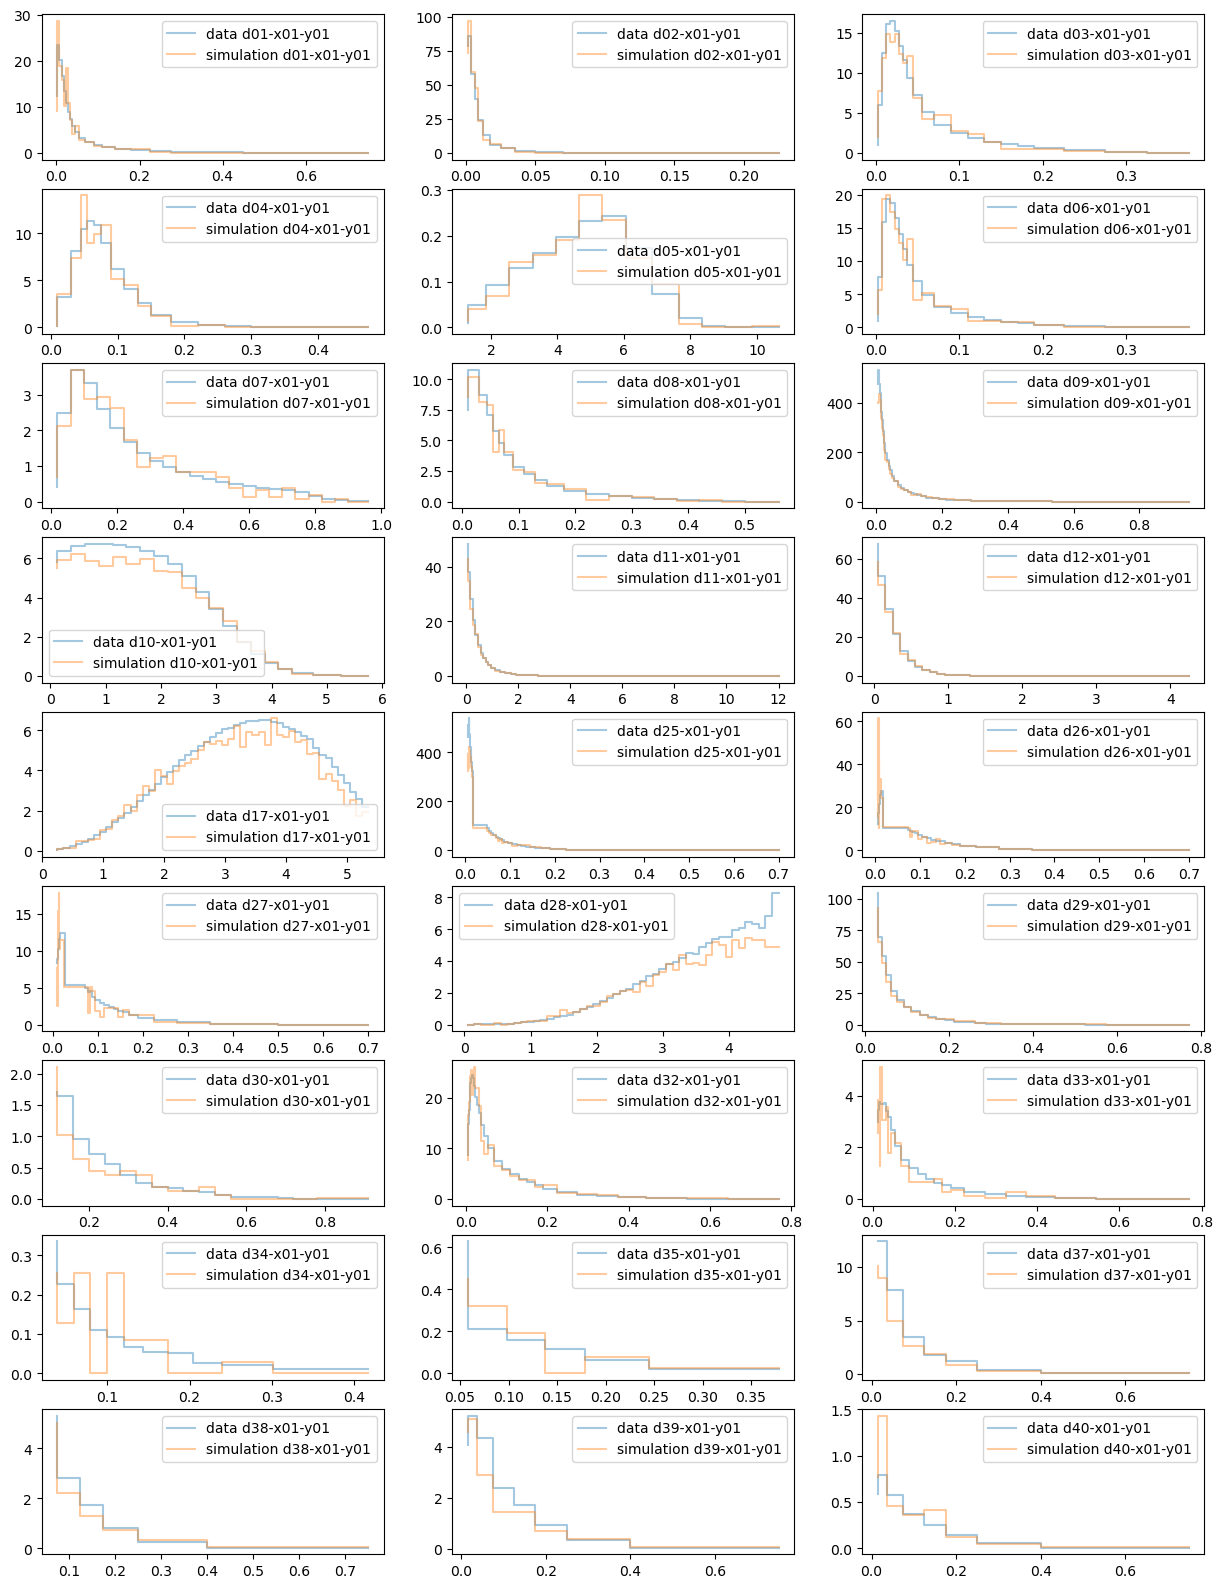

In [32]:
nhists= len(hists)
ncols = 3
nrows = nhists // ncols
nhists= nrows * ncols

fig, ax = plt.subplots(nrows, ncols, figsize=(15, 20), edgecolor='k')
ax = ax.ravel()
for hist_ind, hist in enumerate(hists[:nhists]):
    plt_sim_data_hist(ax[hist_ind], hist)